In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import cPickle as pickle
import PIL
from PIL import Image
import random

import caffe

from lib import run_net
from lib import score_util
from lib import plot_util

from datasets.youtube import youtube
from datasets.pascal_voc import pascal

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (12, 12)

Configure Caffe. **Only necessary for collecting differences, otherwise skip.** 

In [2]:
caffe.set_device(0)
caffe.set_mode_gpu()

net = caffe.Net('../nets/voc-fcn8s.prototxt', '../nets/fcn8s-heavy-pascal.caffemodel', caffe.TEST)

Dataset details

In [3]:
PV = pascal('/x/PASCAL/VOC2011')
YT = youtube('/x/youtube/')

## Frame Differencing

Extract fcn8s on all of the frames that belong to labeled youtube videos for analysis.

In [4]:
def keep_layer(layer):
    """
    Filter layers to keep scores alone
    """
    is_split = 'split' in layer
    is_crop = 'c' == layer[-1]
    is_interp = 'up' in layer
    is_type = layer.startswith('score')
    return is_type and not (is_split or is_crop or is_interp)

def load_layer_diffs(class_, vid, shot):
    diffs = np.load('{}/v1/{}/data/{}/shots/{}/diffs.npz'.format(YT.dir, class_, vid, shot))
    layers = diffs.keys()
    diffs = np.concatenate([d[..., np.newaxis] for l, d in diffs.iteritems()], axis=-1)
    return layers, diffs
    
def segsave(net, path):
    """
    Save maps to disk as compressed arrays.
    """
    for layer, blob in net.blobs.iteritems():
        if keep_layer(layer):
            np.savez('{}-{}.npz'.format(path, layer), blob.data[0])

Run through the frames, difference, and store

- differences in scores (for confidence)
- differences in actual output (proportion of pixels changed)
- differences in data, differences in label

In [5]:
# decide layers to difference
layers = filter(lambda l: keep_layer(l), net.blobs.keys())
print 'layers to difference: {}'.format(layers)

# collect frame differences
for class_ in YT.classes[1:]:  # skip background
    print 'differencing {}'.format(class_)
    for vid in sorted(YT.list_label_vids(class_)):
        print '\tvid {}'.format(vid)
        sys.stdout.flush()
        for shot in YT.list_label_shots(class_, vid):
            # skip if already done
            if os.path.exists('{}/v1/{}/data/{}/shots/{}/diffs.npz'.format(YT.dir, class_, vid, shot)):
                print '\tskipping...'
                continue
            frames = YT.list_frames(class_, vid, shot)
            label_frames = YT.list_label_frames(class_, vid, shot)
            # seek to beginning of labels
            first_label_idx = int(label_frames[0]) - 1
            frames = frames[first_label_idx:]
            # handle first frame
            data = YT.preprocess(YT.load_frame(class_, vid, shot, frames[0]))
            label = YT.convert_yt2voc_label(YT.load_label(class_, vid, shot, frames[0]), class_, PV.classes)
            run_net.segrun(net, data)
            feats = [net.blobs[l].data[0].copy() for l in layers]
            argmaxes = [net.blobs[l].data[0].argmax(axis=0).copy() for l in layers if 'score' in l]
            # differences: layers, then argmaxes, and last is data and label
            diffs = {}
            zeros = np.zeros((len(frames)), dtype=np.float32)
            diffs['data'] = zeros.copy()
            diffs['label'] = zeros.copy()
            for l in layers:
                diffs[l] = zeros.copy()
                diffs[l + '-argmax'] = zeros.copy()
            for ix, frame in enumerate(frames):
                # extract this frame
                new_data = YT.preprocess(YT.load_frame(class_, vid, shot, frame))
                if frame in label_frames:
                    new_label = YT.convert_yt2voc_label(YT.load_label(class_, vid, shot, frame), class_, PV.classes)
                run_net.segrun(net, new_data)
                new_feats = [net.blobs[l].data[0].copy() for l in layers]
                new_argmaxes = [net.blobs[l].data[0].argmax(axis=0).copy() for l in layers if 'score' in l]
                # compute differences
                for lx, l in enumerate(layers):
                    abs_diff = np.abs(new_feats[lx] - feats[lx])
                    abs_avg = (np.abs(new_feats[lx]) + np.abs(feats[lx])) / 2.
                    rel_diff = abs_diff / abs_avg
                    rel_diff[np.isnan(rel_diff)] = 0
                    diffs[l][ix] = rel_diff.mean()
                    diffs[l + '-argmax'][ix] = np.array(new_argmaxes[lx] != argmaxes[lx]).mean()
                diffs['data'][ix] = (np.abs(new_data - data) / ((np.abs(new_data) + np.abs(data)) / 2.)).mean()
                diffs['label'][ix] = np.array(new_label != label).mean()
                # advance over old
                feats, argmaxes, data, label = new_feats, new_argmaxes, new_data, new_label
            np.savez('{}/v1/{}/data/{}/shots/{}/diffs.npz'.format(YT.dir, class_, vid, shot), **diffs)

layers to difference: ['score_fr', 'score_pool4', 'score_pool3', 'score']
differencing aeroplane
	vid 0001
	skipping...
	vid 0002
	skipping...
	vid 0010
	skipping...
	vid 0011
	skipping...
	vid 0012
	skipping...
	vid 0013
	skipping...
differencing bird
	vid 0001
	skipping...
	vid 0007
	skipping...
	vid 0010
	skipping...
	vid 0011
	skipping...
	vid 0012
	skipping...
	vid 0014
	skipping...
differencing boat
	vid 0001
	skipping...
	vid 0003
	skipping...
	vid 0004
	skipping...
	vid 0005
	skipping...
	vid 0006
	skipping...
	vid 0007
	skipping...
	vid 0008
	skipping...
	vid 0009
	skipping...
	vid 0010
	skipping...
	vid 0011
	skipping...
	vid 0012
	skipping...
	vid 0014
	skipping...
	vid 0015
	skipping...
	vid 0016
	skipping...
	vid 0017
	skipping...
differencing car
	vid 0001
	skipping...
	vid 0002
	skipping...
	vid 0003
	skipping...
	vid 0004
	skipping...
	vid 0005
	skipping...
	vid 0008
	skipping...
	vid 0009
	skipping...
differencing cat
	vid 0001
	skipping...
	vid 0002
	skipping...
	vid 

## Inspection

Once the differences have been computed offline and saved, we can inspect the traces.
Start by checking the mean across layers of a given shot.

In [6]:
# show mean differences across layers
layers, diffs = load_layer_diffs('boat', '0011', '001')
for layer, diff in zip(layers, diffs.T):
    print '{:<20}: {}'.format(layer, np.mean(diff))

score-argmax        : 0.0235913135111
score_pool3-argmax  : 0.173584058881
score_fr            : 0.282327950001
label               : 0.0078412136063
score_pool4         : 0.316808968782
score               : 0.290756285191
score_pool3         : 0.2999342978
score_fr-argmax     : 0.0252976194024
data                : 0.351404070854
score_pool4-argmax  : 0.140458166599


Grand mean and standard deviation

In [7]:
all_diffs = []
for class_ in YT.classes:
    for vid in sorted(YT.list_label_vids(class_)):
        for shot in YT.list_label_shots(class_, vid):
            layers, diffs = load_layer_diffs(class_, vid, shot)
            all_diffs.append(diffs)
all_diff_arr = np.concatenate(all_diffs)

means = np.zeros((len(all_diffs), len(layers)))
for ix, diff in enumerate(all_diffs):
    means[ix] = np.mean(diff, axis=0)

for layer, mean in zip(layers, means.T):
    print '{:<20}: {}'.format(layer, np.std(mean))

score-argmax        : 0.0206552718364
score_pool3-argmax  : 0.0546926715348
score_fr            : 0.120616351528
label               : 0.00458718119848
score_pool4         : 0.102406660096
score               : 0.12047903273
score_pool3         : 0.093659251823
score_fr-argmax     : 0.0206845826048
data                : 0.178912213557
score_pool4-argmax  : 0.0592727472488


Plot difference traces for a random video

dog 0009 001


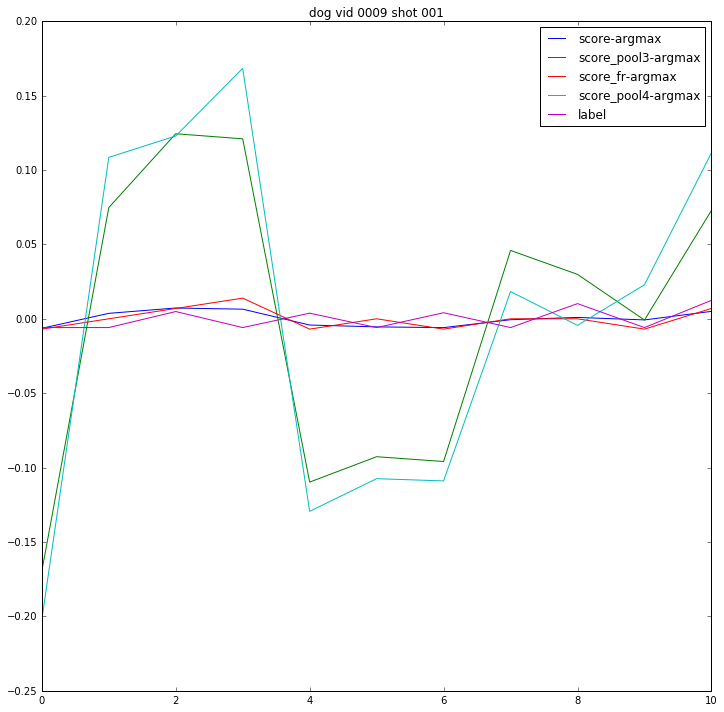

In [8]:
class_ = random.choice(YT.classes)
vid = random.choice(YT.list_label_vids(class_))
shot = random.choice(YT.list_label_shots(class_, vid))
print class_, vid, shot

layers, diffs = load_layer_diffs(class_, vid, shot)
diff_means = np.mean(diffs, axis=0)

plot_layers = [l for l in layers if 'argmax' in l] + ['label']
plot_ix = [layers.index(l) for l in plot_layers]

plt.figure()
plt.title('{} vid {} shot {}'.format(class_, vid, shot))
plt.plot(diffs[:, plot_ix] - diff_means[plot_ix])
plt.legend(plot_layers)